In [1]:
from lib import cnn_tester
import sys
sys.path.insert(0, '../src')
from lib import datasets

from os.path import join as opj
import pandas as pd
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro

import seaborn as sns

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)
simplefilter(action='ignore', category=RuntimeWarning)

# Hyperparameters validation - Computation of performance

In [2]:
# Directories
data_dir = '../data/preprocessed/HCP_dataset'
out_dir = '../data/derived/HCP_dataset'

In [3]:
# Specific setup
preprocess_type = 'resampled_masked_normalized'

# Training setup 
train_subset ='hcp_dataset'
lr = '1e-04'
model_to_test = ['model_cnn_4layers', 'model_cnn_5layers']
init_to_test = ['retrain_no', 'retrain_all']
batch_to_test = [32, 64]
epochs_to_test = ['epochs_200', 'final']

In [4]:
# Supplementary Figure S2 - Performance on classification of global HCP dataset of models 
# with different hyperparameters. 

accuracies = []
f1_list = []
model_list = []
arch_list = []
epochs_list = []
batch_list = []
prec_list = []
rec_list = []

if not os.path.exists('../figures/validation_model_hcp.csv'):
    print('Calculating validation performance...')
    for model in model_to_test:
        for init in init_to_test:
            for epochs in epochs_to_test:
                for batch in batch_to_test:
                    for i in range(5):
                        model_list.append(init)
                        arch_list.append(model)
                        batch_list.append(batch)
                        epochs_list.append(epochs)
                        
                        test_id_file = opj(data_dir, f'test_hp_hcp_dataset_fold_{i}.txt')
                        label_file = opj(data_dir, f'hcp_dataset_labels.csv')
                        label_col = 'contrast'
                        label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                                     f'hcp_dataset_labels.csv'))

                        label_list = sorted(np.unique(label_filelist['contrast']))

                        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                                          label_list)
                        # Model to test
                        parameter_file = opj(out_dir, f"{train_subset}_maps_classification_contrast_{model}_" + \
                                f"valid_hp_{init}_{preprocess_type}_epochs_500_batch_size_{batch}_lr_{lr}", 
                                             f"model_{epochs}_fold_{i}.pt")

                        acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file) # Compute results

                        accuracies.append(acc)
                        f1_list.append(f1)
                        prec_list.append(prec)
                        rec_list.append(rec)
                    
    # Creation of dataframe with results
    init_list = ['Default algorithm' if i == 'retrain_no' else 'Pre-trained CAE' for i in model_list]

    arch_list = ['5 layers' if i == 'model_cnn_5layers' else '4 layers' for i in arch_list]

    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Initialization']=init_list
    df['Batch']=batch_list
    df['Epochs']=epochs_list
    df['Architecture']=arch_list
    df['Precision']=prec_list
    df['Recall']=rec_list

    df.to_csv('../figures/validation_model_hcp.csv') 
    
else: 
    print('Validation metrics already computed.')

Validation metrics already computed.


In [5]:
# DF with mean value per set of hyperparameters (average across folds)
df = pd.read_csv('../figures/validation_model_hcp.csv') 

df_mean = pd.DataFrame(columns=['Initialization', 'Batch', 'Epochs', 'Architecture','Accuracy', 'F1'])
for init in ['Default algorithm', 'Pre-trained CAE']:
    for model in ['4 layers', '5 layers']:
        for batch in batch_to_test:
            for epochs in epochs_to_test:
                df_mean = df_mean.append({'Initialization':init, 'Batch':batch, 'Epochs':epochs, 'Architecture':model, 
                          'Accuracy': np.mean(df['Accuracy'][df['Architecture']==model][df['Initialization']==init][df['Epochs']==epochs][df['Batch']==batch]), 
                          'F1': np.mean(df['F1'][df['Architecture']==model][df['Initialization']==init][df['Epochs']==epochs][df['Batch']==batch])}, 
                         ignore_index=True)

# Hyperparameter validation - Exploration of results

### Table 3 - Hyperparameters chosen for each dataset and corresponding performance of the classifier on the validation set of the dataset 

Here, we computed the results of Table 3 for HCP dataset.

In [6]:
df_mean[df_mean['Initialization']=='Default algorithm'].nlargest(1, ['Accuracy', 'F1'])

,Initialization,Batch,Epochs,Architecture,Accuracy,F1
1,Default algorithm,32,final,4 layers,0.907933,0.907703


In [7]:
df_mean[df_mean['Initialization']=='Pre-trained CAE'].nlargest(1, ['Accuracy', 'F1'])

,Initialization,Batch,Epochs,Architecture,Accuracy,F1
14,Pre-trained CAE,64,epochs_200,5 layers,0.91842,0.918386


# Evaluation of models performance

## Contrast classification - Table 4 and Figure 5

In [8]:
# Table 4 - Classification performance on HCP datasets of models initialized with default algorithm vs 
# with the weights of a pre-trained CAE. 
# PART 1 - CLASSIFICATION OF CONTRASTS 
if not os.path.exists('../figures/test_hcp_contrast_sample_size.csv'):
    print('Calculating performance...')
    accuracies = []
    f1_list = []
    prec_list = []
    rec_list = []
    prec_list = []
    model_list = []
    n_list=[]

    lr = '1e-04'

    for n in ['50', '100', '200', 'global']: # Iterates on all sample sizes 
        # Name of the training set used 
        train_subset ='hcp_dataset_' + n
        test_subset = 'hcp_dataset_' + n

        if n =='global':
            train_subset = 'hcp_dataset'
            test_subset ='hcp_dataset'
            
        for i in range(5):
            # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
            test_id_file = opj(data_dir, f'test_perf_hcp_dataset_fold_{i}.txt')
            label_file = opj(data_dir, f'hcp_dataset_labels.csv')
            label_col = 'contrast'
            label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                         f'hcp_dataset_labels.csv'))

            label_list = sorted(np.unique(label_filelist['contrast']))

            test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                              label_list)

            # Compute results performance for DEFAULT ALGORITHM
            model = 'model_cnn_4layers_valid_perf_retrain_no'
            epochs = 500
            batch=32
            model_list.append('Default algorithm')
            parameter_file = opj(out_dir, 
        f'{train_subset}_maps_classification_contrast_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

            accuracies.append(acc)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)

            # Compute results performance for PRE-TRAINED CAE 
            model = 'model_cnn_5layers_valid_perf_retrain_all'
            epochs = 200
            batch=64
            model_list.append('Pre-trained CAE')

            parameter_file = opj(out_dir, 
                f'{train_subset}_maps_classification_{label_col}_' + \
                                 f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_final_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

            accuracies.append(acc)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)
            
    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Precision']=prec_list
    df['Recall']= rec_list
    df['Subject']=n_list

    df.to_csv('../figures/test_hcp_contrast_sample_size.csv') # Global dataframe 
else:
    print('Performance already computed.')

Performance already computed.


In [9]:
df = pd.read_csv('../figures/test_hcp_contrast_sample_size.csv')

In [10]:
# Mean values
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub]) * 100, 1)))
    
    print('Pre-trained CAE')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub]) * 100, 1)))

Sample 50
Default algorithm
83.6
Pre-trained CAE
87.0
Sample 100
Default algorithm
86.8
Pre-trained CAE
89.9
Sample 200
Default algorithm
88.6
Pre-trained CAE
90.2
Sample global
Default algorithm
90.9
Pre-trained CAE
92.4


In [11]:
#Standard errors
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.std(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub])/np.sqrt(5) * 100, 2)))
    
    print('Pre-trained CAE')
    print(str(round(np.std(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub])/np.sqrt(5) * 100, 2)))

Sample 50
Default algorithm
0.61
Pre-trained CAE
0.51
Sample 100
Default algorithm
0.69
Pre-trained CAE
0.34
Sample 200
Default algorithm
0.84
Pre-trained CAE
1.46
Sample global
Default algorithm
0.38
Pre-trained CAE
0.44


In [12]:
#T-test
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('T-stat', str(round(stats.ttest_rel(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub].tolist(), 
                                   df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub].tolist())[0], 2)))
    print('p-value', str(round(stats.ttest_rel(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub], 
                                   df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub])[1], 4)))

Sample 50
T-stat -11.52
p-value 0.0003
Sample 100
T-stat -4.77
p-value 0.0088
Sample 200
T-stat -1.42
p-value 0.2291
Sample global
T-stat -4.74
p-value 0.0091


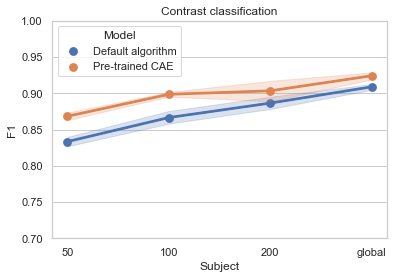

In [13]:
# Plot figure 
sns.set_theme(style="whitegrid")

ax = sns.pointplot(x="Subject", y="F1", hue="Model",
                 data=df, ci=None)

ax = sns.lineplot(x="Subject", y="F1", hue="Model",
                 data=df, ci=68, legend=False)

ax.set_title("Contrast classification")
ax.set_ylim(0.70, 1)

ax.figure.savefig('../figures/fig5.png')

## Task classification - Table 4 and Figure 6

In [14]:
# Table 4 - Classification performance on HCP datasets of models initialized with default algorithm vs 
# with the weights of a pre-trained CAE. 
# PART 1 - CLASSIFICATION OF CONTRASTS 
if not os.path.exists('../figures/test_hcp_task_sample_size.csv'):
    print('Calculating performance...')
    accuracies = []
    f1_list = []
    prec_list = []
    rec_list = []
    prec_list = []
    model_list = []
    n_list=[]

    lr = '1e-04'

    for n in ['50', '100', '200', 'global']: # Iterates on all sample sizes 
        # Name of the training set used 
        train_subset ='hcp_dataset_' + n
        test_subset = 'hcp_dataset_' + n

        if n =='global':
            train_subset = 'hcp_dataset'
            test_subset ='hcp_dataset'
            
        for i in range(5):
            # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
            test_id_file = opj(data_dir, f'test_perf_hcp_dataset_fold_{i}.txt')
            label_file = opj(data_dir, f'hcp_dataset_labels.csv')
            label_col = 'task'
            label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                         f'hcp_dataset_labels.csv'))

            label_list = sorted(np.unique(label_filelist['task']))

            test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                              label_list)

            # Compute results performance for DEFAULT ALGORITHM
            model = 'model_cnn_4layers_valid_perf_retrain_no'
            epochs = 500
            batch=32
            model_list.append('Default algorithm')
            parameter_file = opj(out_dir, 
        f'{train_subset}_maps_classification_task_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

            accuracies.append(acc)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)

            # Compute results performance for PRE-TRAINED CAE 
            model = 'model_cnn_5layers_valid_perf_retrain_all'
            epochs = 200
            batch=64
            model_list.append('Pre-trained CAE')

            parameter_file = opj(out_dir, 
                f'{train_subset}_maps_classification_{label_col}_' + \
                                 f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_final_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

            accuracies.append(acc)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)
            
    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Precision']=prec_list
    df['Recall']= rec_list
    df['Subject']=n_list

    df.to_csv('../figures/test_hcp_task_sample_size.csv') # Global dataframe 
else:
    print('Performance already computed.')

Performance already computed.


In [15]:
df = pd.read_csv('../figures/test_hcp_task_sample_size.csv')

In [16]:
# Mean values
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub]) * 100, 1)))
    
    print('Pre-trained CAE')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub]) * 100, 1)))

Sample 50
Default algorithm
96.6
Pre-trained CAE
97.3
Sample 100
Default algorithm
95.4
Pre-trained CAE
98.0
Sample 200
Default algorithm
97.9
Pre-trained CAE
98.5
Sample global
Default algorithm
98.4
Pre-trained CAE
99.0


In [17]:
#Standard errors
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.std(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub])/np.sqrt(5) * 100, 2)))
    
    print('Pre-trained CAE')
    print(str(round(np.std(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub])/np.sqrt(5) * 100, 2)))

Sample 50
Default algorithm
0.47
Pre-trained CAE
0.43
Sample 100
Default algorithm
1.49
Pre-trained CAE
0.25
Sample 200
Default algorithm
0.44
Pre-trained CAE
0.16
Sample global
Default algorithm
0.17
Pre-trained CAE
0.13


In [18]:
#T-test
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('T-stat',str(round(stats.ttest_rel(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub].tolist(), 
                                   df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub].tolist())[0], 2)))
    print('P-value', str(round(stats.ttest_rel(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub], 
                                   df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub])[1], 4)))

Sample 50
T-stat -3.57
P-value 0.0235
Sample 100
T-stat -1.4
P-value 0.2349
Sample 200
T-stat -1.5
P-value 0.2084
Sample global
T-stat -5.65
P-value 0.0048


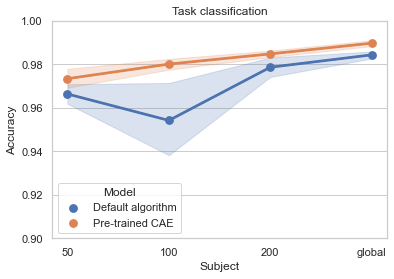

In [19]:
# Plot figure 
sns.set_theme(style="whitegrid")

ax = sns.pointplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=None)

ax = sns.lineplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=68, legend=False)

ax.set_title("Task classification")
ax.set_ylim(0.90, 1)

ax.figure.savefig('../figures/fig6.png')

## One contrast task classification - Table 4 and Figure 7

In [20]:
if not os.path.exists('../figures/test_hcp_one_contrast_task_sample_size.csv'):
    print('Calculating performance...')
    accuracies = []
    f1_list = []
    prec_list = []
    rec_list = []
    model_list = []
    n_list=[]

    lr = '1e-04'

    for n in ['50', '100', '200', 'global']: # Iterates on all sample sizes 
        # Name of the training set used 
        train_subset ='small_hcp_dataset_' + n
        test_subset = 'small_hcp_dataset_' + n

        if n =='global':
            train_subset = 'small_hcp_dataset'
            test_subset ='small_hcp_dataset'
            
        for i in range(5):
            # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
            test_id_file = opj(data_dir, f'test_perf_small_hcp_dataset_fold_{i}.txt')
            label_file = opj(data_dir, f'small_hcp_dataset_labels.csv')
            label_col = 'task'
            label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                         f'small_hcp_dataset_labels.csv'))

            label_list = sorted(np.unique(label_filelist['task']))

            test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                              label_list)

            # Compute results performance for DEFAULT ALGORITHM
            model = 'model_cnn_4layers_valid_perf_retrain_no'
            epochs = 500
            batch=32
            model_list.append('Default algorithm')
            parameter_file = opj(out_dir, 
        f'{train_subset}_maps_classification_task_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

            accuracies.append(acc)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)

            # Compute results performance for PRE-TRAINED CAE 
            model = 'model_cnn_5layers_valid_perf_retrain_all'
            epochs = 200
            batch=64
            model_list.append('Pre-trained CAE')

            parameter_file = opj(out_dir, 
                f'{train_subset}_maps_classification_{label_col}_' + \
                                 f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_final_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

            accuracies.append(acc)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)
            
    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Precision']=prec_list
    df['Recall']= rec_list
    df['Subject']=n_list

    df.to_csv('../figures/test_hcp_one_contrast_task_sample_size.csv') # Global dataframe 
else:
    print('Performance already computed.')

Performance already computed.


In [21]:
df = pd.read_csv('../figures/test_hcp_one_contrast_task_sample_size.csv')

In [22]:
# Mean values 
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub]) * 100, 1)))
    
    print('Pre-trained CAE')
    print(str(round(np.mean(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub]) * 100, 1)))

Sample 50
Default algorithm
97.9
Pre-trained CAE
99.1
Sample 100
Default algorithm
98.9
Pre-trained CAE
99.4
Sample 200
Default algorithm
99.3
Pre-trained CAE
99.6
Sample global
Default algorithm
99.4
Pre-trained CAE
99.6


In [23]:
#Standard errors
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('Default algorithm')
    print(str(round(np.std(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub])/np.sqrt(5) * 100, 2)))
    
    print('Pre-trained CAE')
    print(str(round(np.std(df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub])/np.sqrt(5) * 100, 2)))

Sample 50
Default algorithm
0.3
Pre-trained CAE
0.3
Sample 100
Default algorithm
0.17
Pre-trained CAE
0.25
Sample 200
Default algorithm
0.2
Pre-trained CAE
0.2
Sample global
Default algorithm
0.2
Pre-trained CAE
0.14


In [24]:
#T-test
for sub in ['50', '100', '200', 'global']:
    print('Sample', sub)
    print('T-stat', str(round(stats.ttest_rel(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub].tolist(), 
                                   df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub].tolist())[0], 2)))
    print('p-value', str(round(stats.ttest_rel(df['Accuracy'][df['Model']=='Default algorithm'][df['Subject']==sub], 
                                   df['Accuracy'][df['Model']=='Pre-trained CAE'][df['Subject']==sub])[1], 4)))

Sample 50
T-stat -4.17
p-value 0.014
Sample 100
T-stat -3.32
p-value 0.0294
Sample 200
T-stat -2.33
p-value 0.08
Sample global
T-stat -2.06
p-value 0.1085


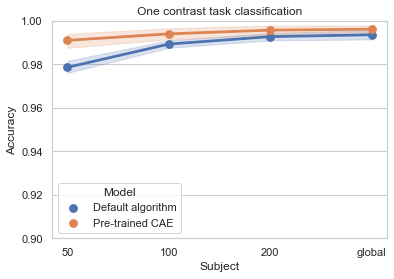

In [25]:
# Plot figure
sns.set_theme(style="whitegrid")

ax = sns.pointplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=None)

ax = sns.lineplot(x="Subject", y="Accuracy", hue="Model",
                 data=df, ci=68, legend=False)

ax.set_title("One contrast task classification")
ax.set_ylim(0.90, 1.00)

ax.figure.savefig('../figures/fig7.png')

## Latent space observation

### Models to study
We selected the models for which the difference in terms of performance between default and pre-trained model was the largest. Thus, we used the sample n=50 of HCP dataset for contrast classification. 

In [3]:
from lib import latent_space_analysis, visualize_features
ae_latent = '../data/derived/NeuroVault_dataset/neurovault_dataset_maps_resampled_masked_normalized_neurovault_dataset_epochs_200_batch_size_32_model_cnn_5layers_lr_1e-04/model_final.pt'

cnn_di_latent = '../data/derived/HCP_dataset/hcp_dataset_50_maps_classification_contrast_model_cnn_4layers_valid_perf_retrain_no_resampled_masked_normalized_epochs_500_batch_size_32_lr_1e-04/model_final_fold_0.pt'

cnn_pt_latent = '../data/derived/HCP_dataset/hcp_dataset_50_maps_classification_contrast_model_cnn_5layers_valid_perf_retrain_all_resampled_masked_normalized_epochs_200_batch_size_64_lr_1e-04/model_final_fold_0.pt'

/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [4]:
# Define test dataset 
import sys
from os.path import join as opj
sys.path.insert(0, '../src')
from lib import datasets
import pandas as pd
import numpy as np

data_dir = '../data/preprocessed/HCP_dataset/'
preprocess_type = 'resampled_masked_normalized'
test_id_file = opj(data_dir, f'test_perf_hcp_dataset_fold_0.txt')
label_file = opj(data_dir, f'hcp_dataset_labels.csv')
label_col = 'contrast'
label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                             f'hcp_dataset_labels.csv'))

label_list = sorted(np.unique(label_filelist['contrast']))

test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                  label_list)

In [5]:
# Computing per-class accuracies for the first fold of the performance set 
# to find the contrasts for which models struggle to classify 
from lib import cnn_tester
print('Calculating performance...')
out_dir = '../data/derived/HCP_dataset'
accuracies = []
f1_list = []
prec_list = []
rec_list = []
prec_list = []
model_list = []
n_list=[]

lr = '1e-04'

train_subset ='hcp_dataset_50'
test_subset = 'hcp_dataset_50'

for i in range(1):
    # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
    test_id_file = opj(data_dir, f'test_perf_hcp_dataset_fold_{i}.txt')
    label_file = opj(data_dir, f'hcp_dataset_labels.csv')
    label_col = 'contrast'
    label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                 f'hcp_dataset_labels.csv'))

    label_list = sorted(np.unique(label_filelist['contrast']))

    test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                      label_list)

    # Compute results performance for DEFAULT ALGORITHM
    model = 'model_cnn_4layers_valid_perf_retrain_no'
    epochs = 500
    batch=32
    model_list.append('Default algorithm')
    parameter_file = opj(out_dir, 
f'{train_subset}_maps_classification_contrast_{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                 f'model_final_fold_{i}.pt')

    acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)

    acc_class_di = acc_class

    # Compute results performance for PRE-TRAINED CAE 
    model = 'model_cnn_5layers_valid_perf_retrain_all'
    epochs = 200
    batch=64
    model_list.append('Pre-trained CAE')

    parameter_file = opj(out_dir, 
        f'{train_subset}_maps_classification_{label_col}_' + \
                         f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                 f'model_final_fold_{i}.pt')

    acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)
    acc_class_pt = acc_class

Calculating performance...


/Users/egermani/Documents/self_taught_decoding/results/../src/lib/model_cnn_4layers.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
/Users/egermani/miniforge3/envs/workEnv/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [6]:
lab_to_analyze=[]
for lab in range(len(label_list)):
    if acc_class_di['Good predictions'].iloc[lab] < 60 or acc_class_pt['Good predictions'].iloc[lab] < 60:
        print('Bad pred:', label_list[lab])
        lab_to_analyze.append(label_list[lab])     

Bad pred: 0BK_BODY
Bad pred: 0BK_PLACE
Bad pred: 0BK_TOOL
Bad pred: 2BK_BODY
Bad pred: 2BK_TOOL
Bad pred: PUNISH
Bad pred: REL
Bad pred: REWARD


In [7]:
# Selection of random subjects for which we will plot the features 
import random 
subjects = random.sample(test_set.get_original_subject(), 5)

0BK_BODY


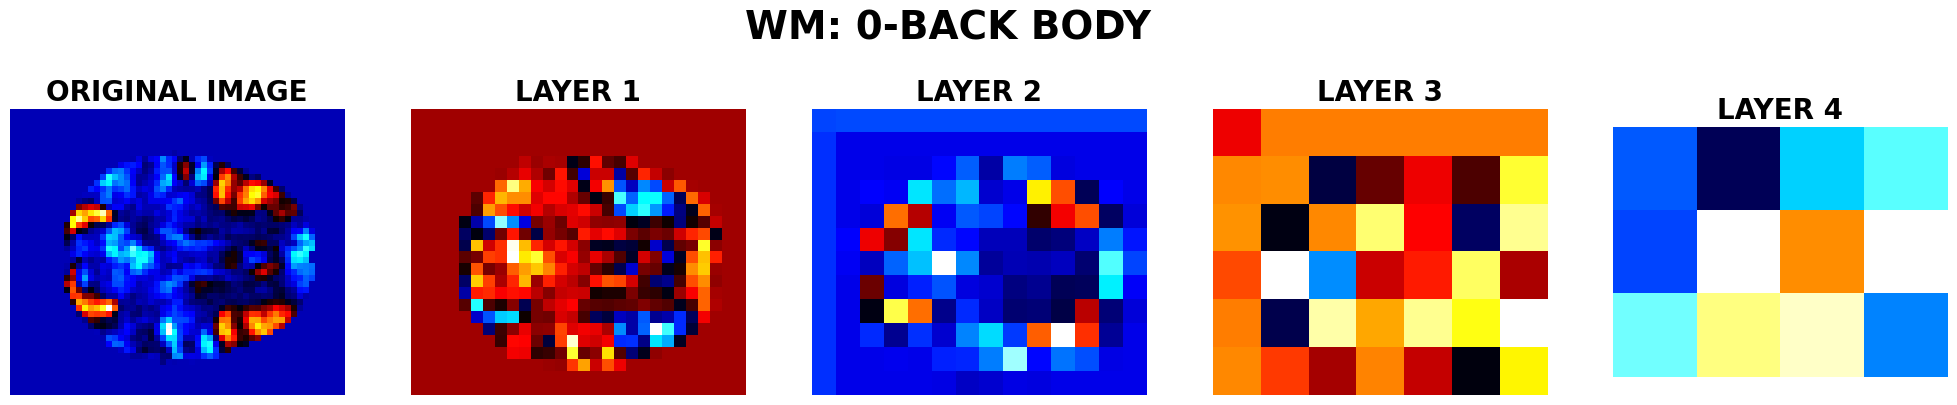

0BK_PLACE


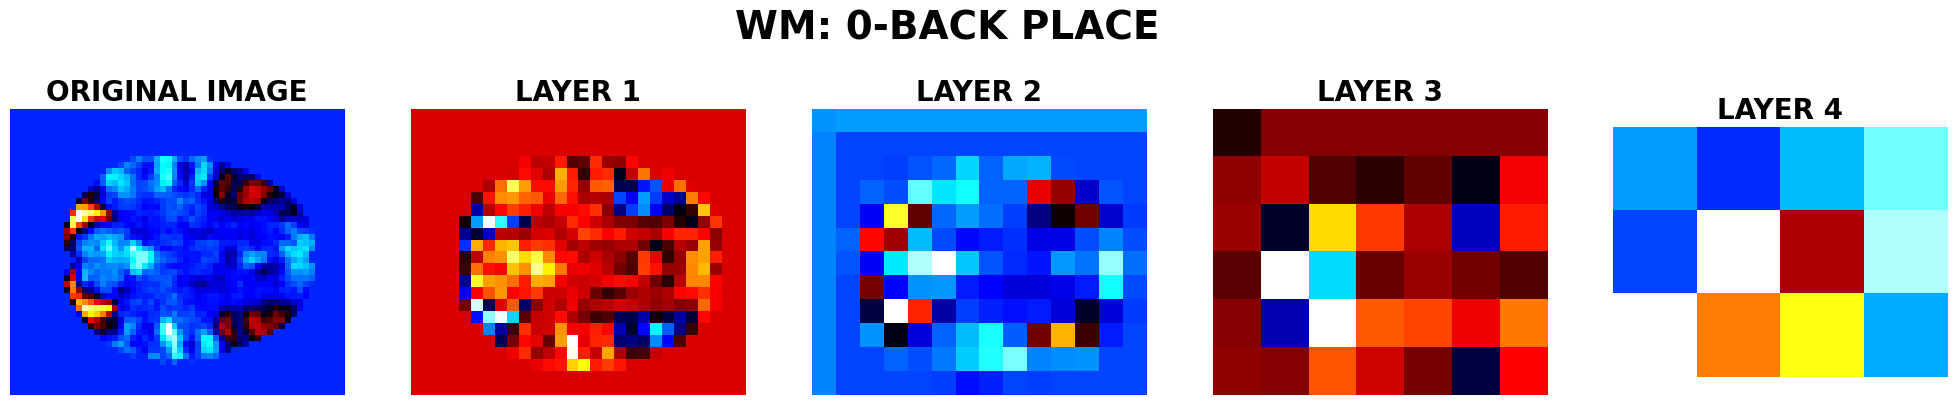

0BK_TOOL


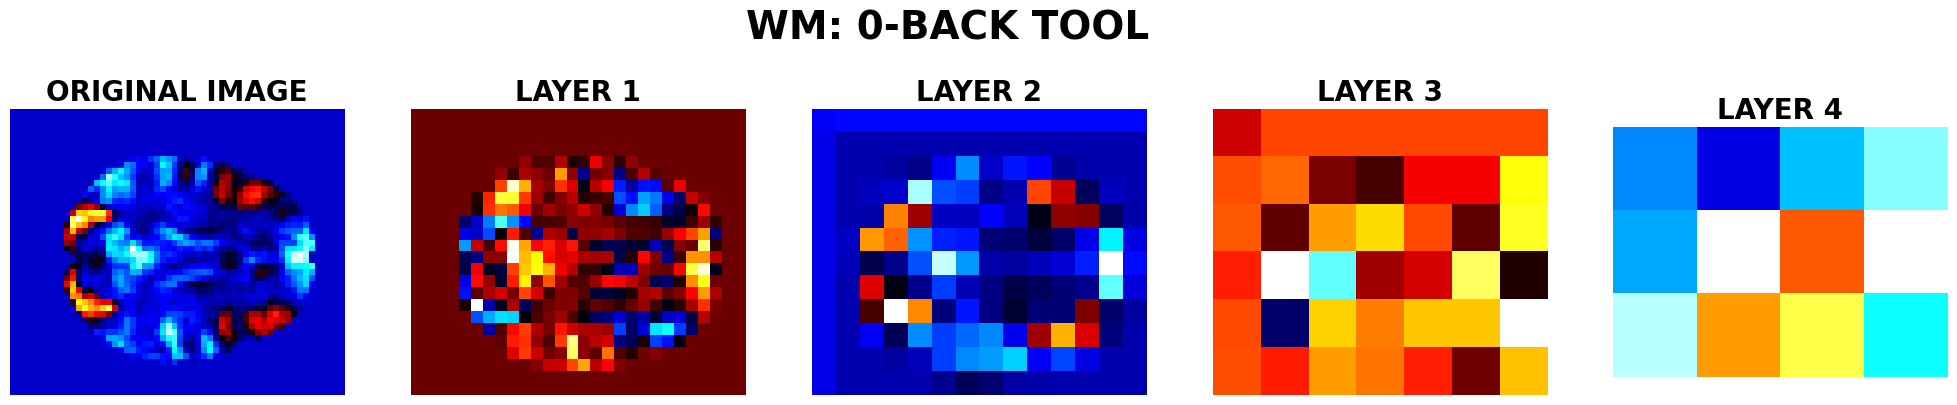

2BK_BODY


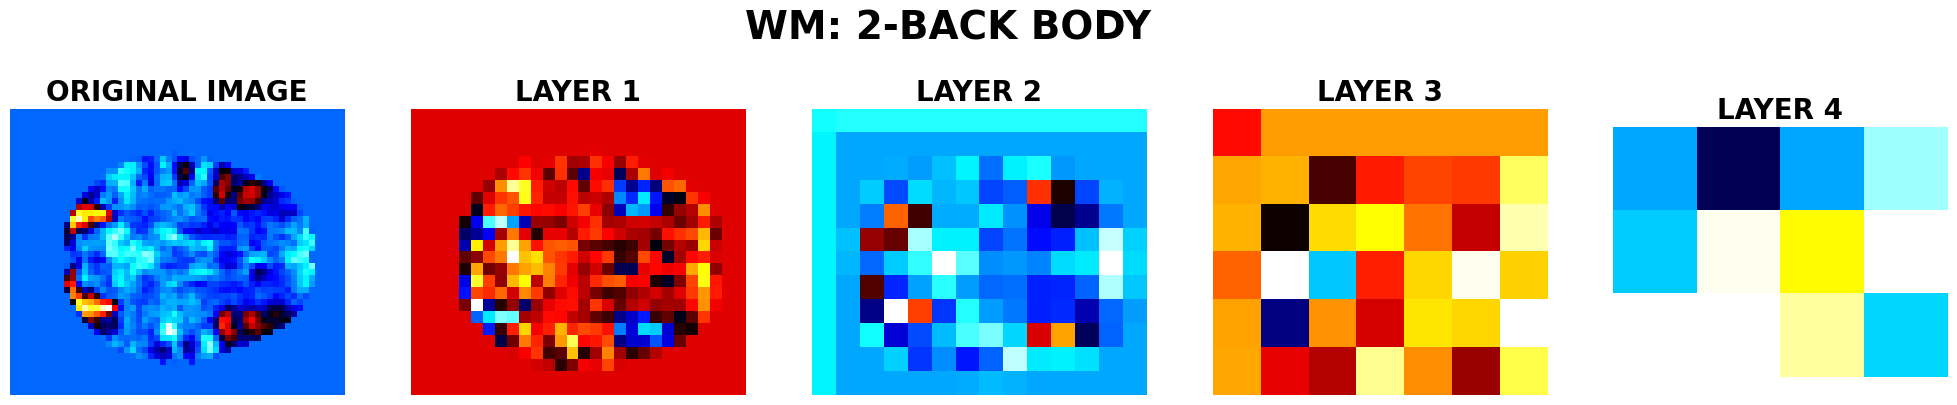

2BK_TOOL


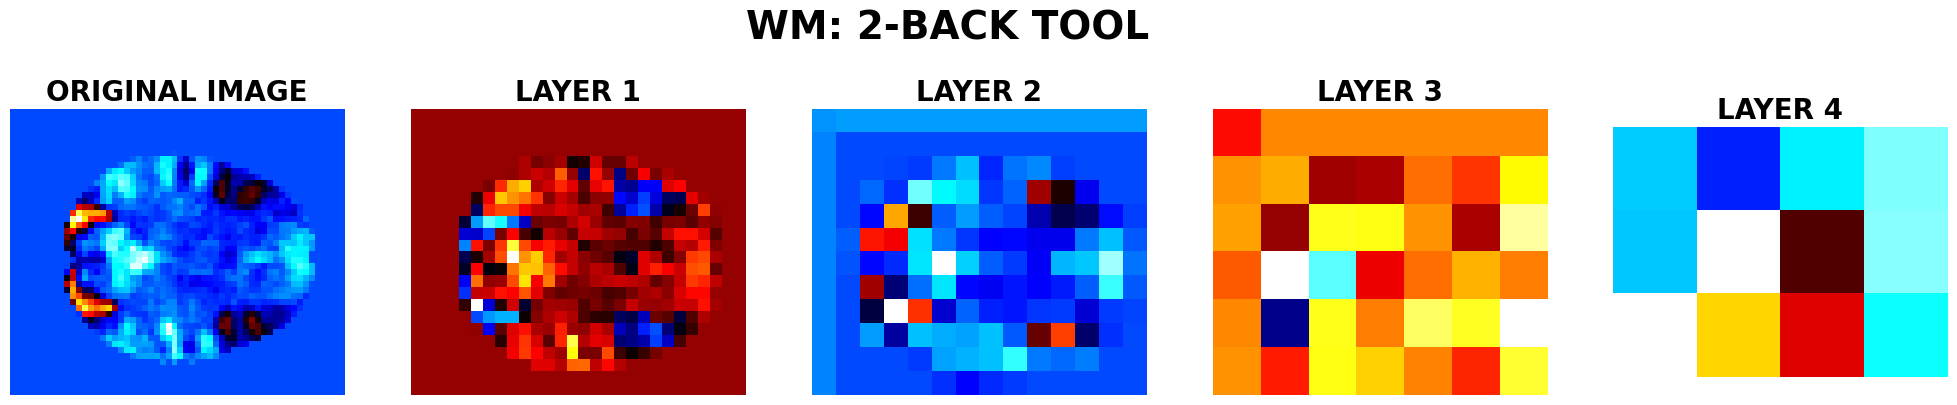

PUNISH


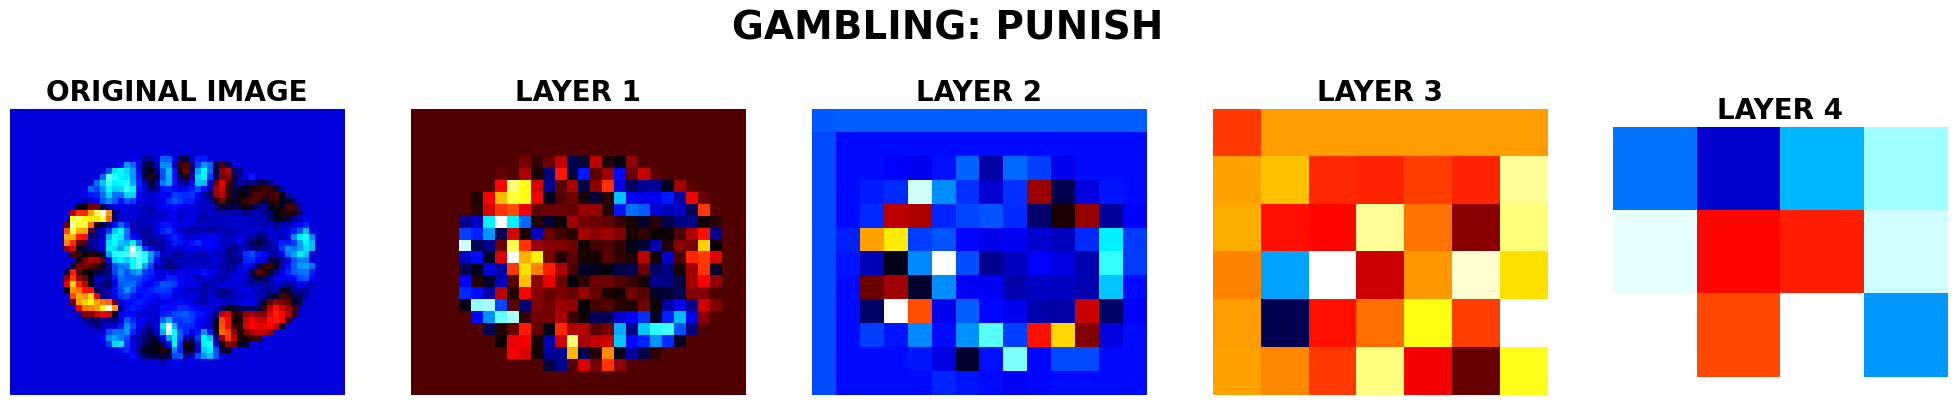

REL


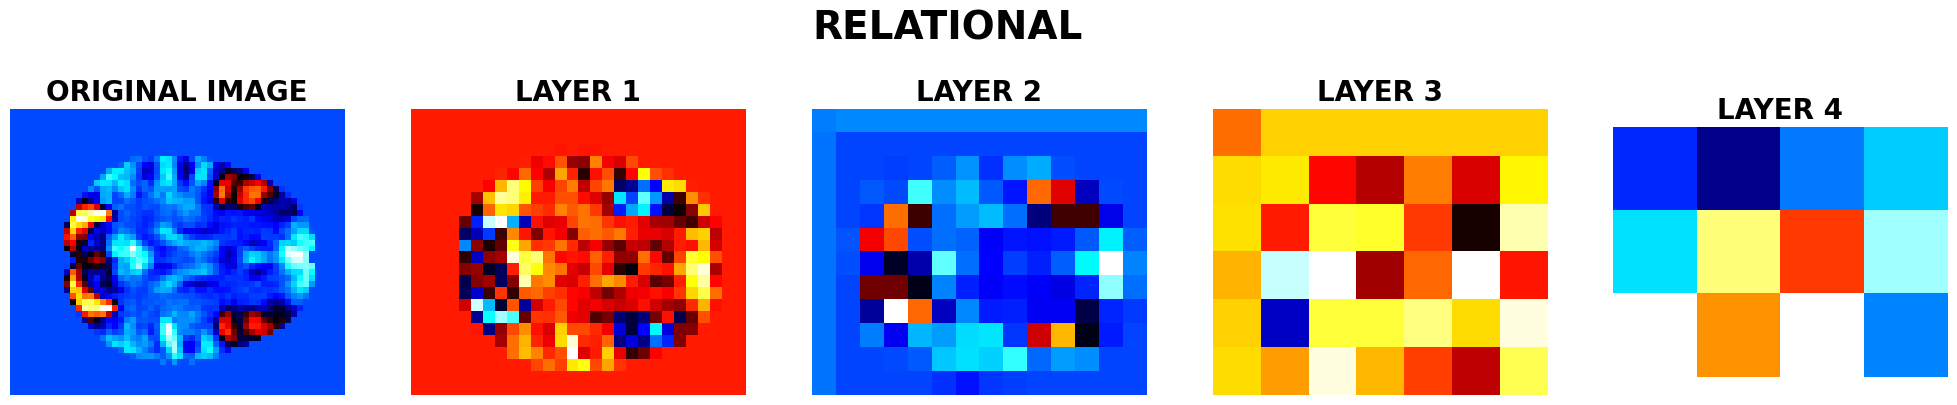

REWARD


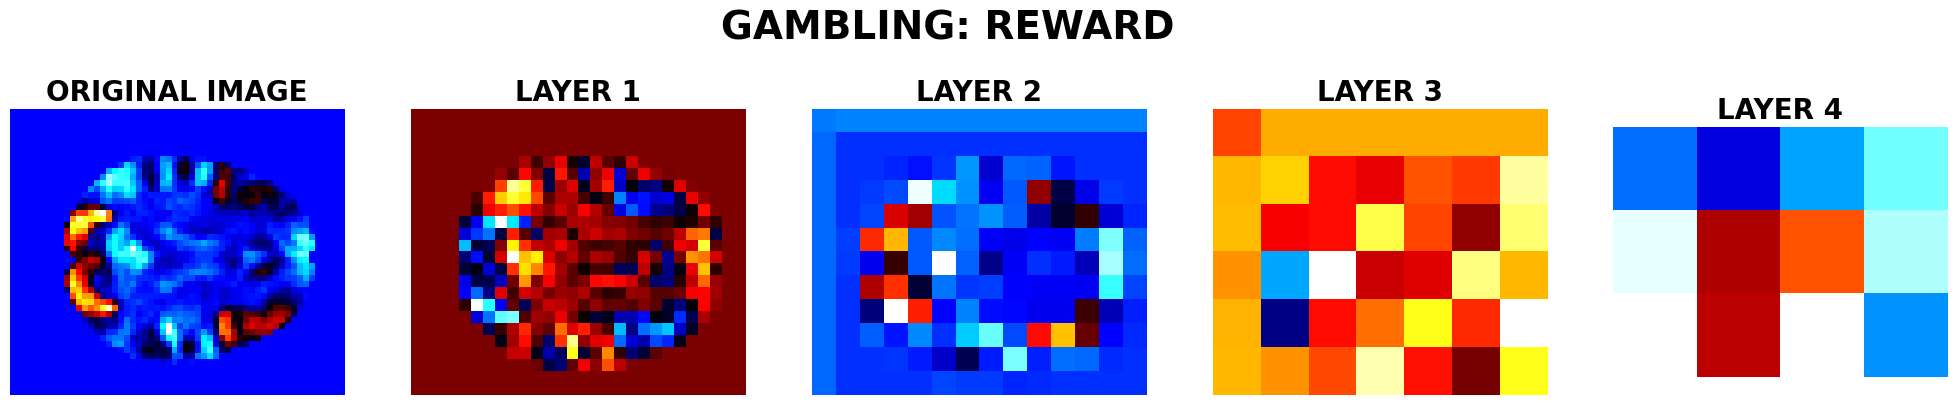

In [8]:
import importlib
importlib.reload(visualize_features)
correlations={}
classes_names = ['WM: 0-BACK BODY', 'WM: 0-BACK PLACE', 'WM: 0-BACK TOOL','WM: 2-BACK BODY','WM: 2-BACK TOOL',
                 'GAMBLING: PUNISH', 'RELATIONAL', 'GAMBLING: REWARD']
for i, classes in enumerate(lab_to_analyze):
    print(classes)
    p=True
    correlations[classes] =visualize_features.visualize_features(cnn_di_latent, 
                                                                    test_set, classe=classes, classe_name=classes_names[i],
                                                                    types='DI', print_title=p)

In [9]:
for classes in lab_to_analyze:
    print(classes)
    print(np.mean(correlations[classes][0]))
    print(np.mean(correlations[classes][1]))
    print(np.mean(correlations[classes][2]))
    print(np.mean(correlations[classes][3]))
    print(np.mean(correlations[classes][4]))

0BK_BODY
0.2854587883179037
0.2767404510917888
0.43462231448295946
0.4129525604279607
0.7159017731492422
0BK_PLACE
0.33772627197246274
0.3270874542551642
0.49738197210670465
0.5033819161220868
0.7901831663167125
0BK_TOOL
0.31288357944711576
0.29152341395637343
0.4495820284974568
0.45363942948755015
0.7487673654506124
2BK_BODY
0.25956177836624095
0.2541315652025116
0.4172698712134039
0.3957259649198835
0.7214058487555677
2BK_TOOL
0.32423889344485285
0.30763005299131013
0.47461403184657686
0.4889710973484938
0.7891776878270028
PUNISH
0.31270012644885725
0.2965415303386819
0.4445054211899516
0.46279654121882663
0.6906602304926318
REL
0.4400231677300341
0.4273514485884379
0.5950712567963219
0.5326178977278274
0.7384021723485499
REWARD
0.33878351330558004
0.3210272937154082
0.473681337805303
0.47870405441134506
0.7080678749387146


0BK_BODY


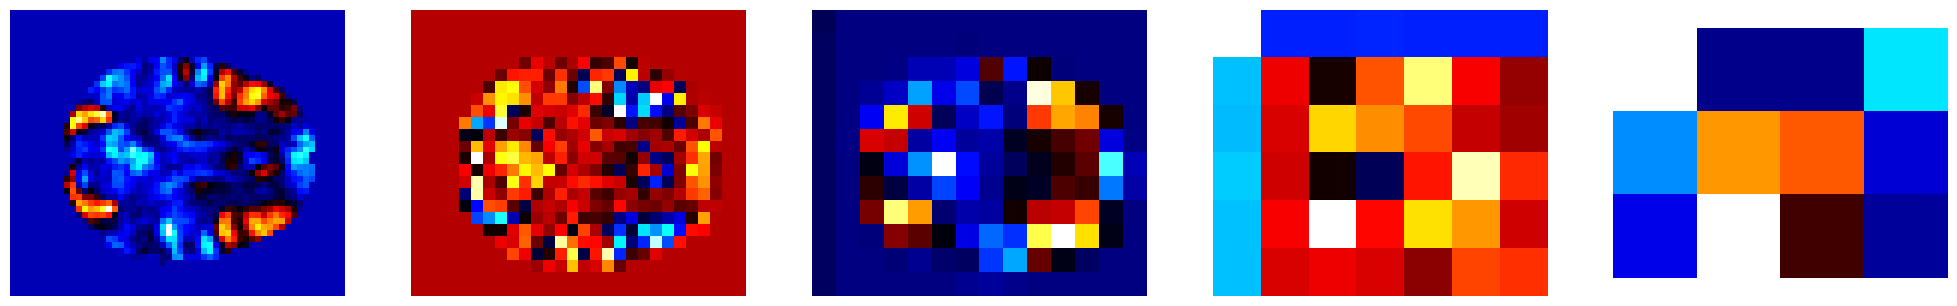

0BK_PLACE


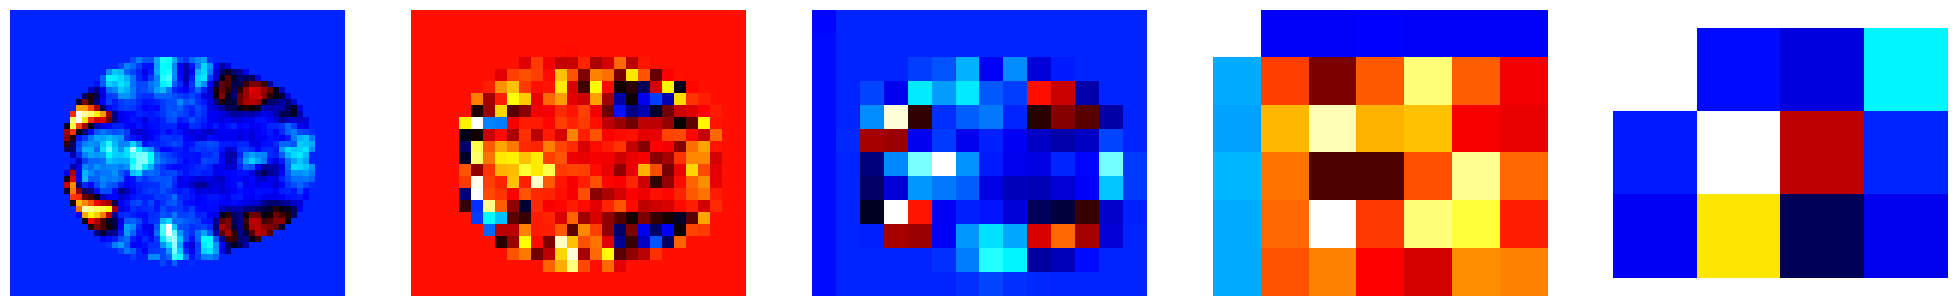

0BK_TOOL


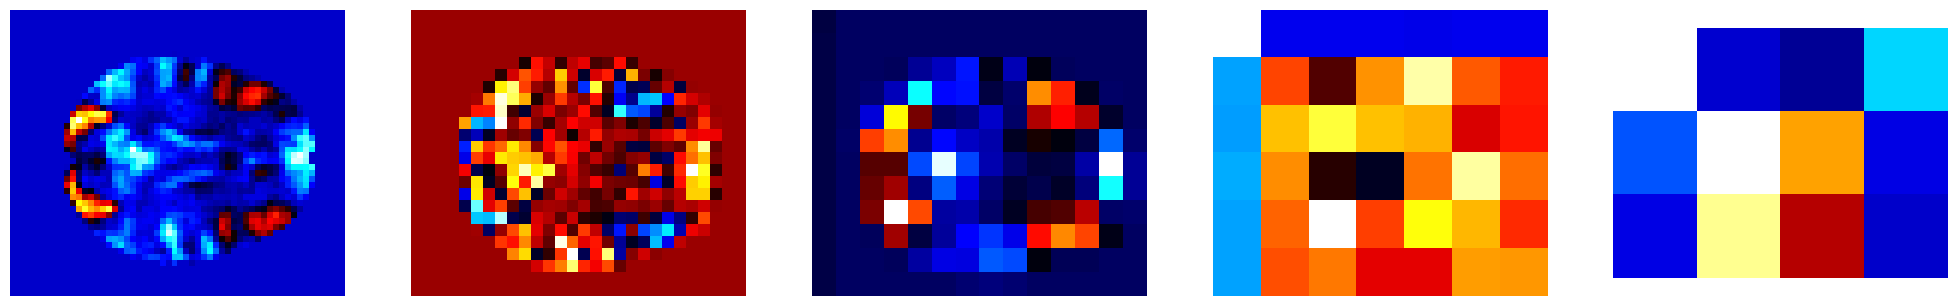

2BK_BODY


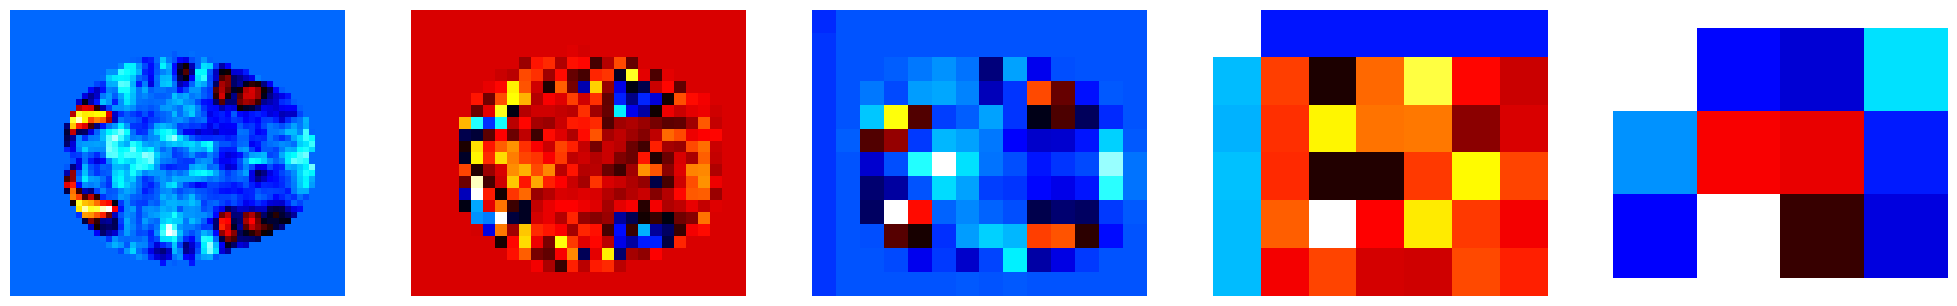

2BK_TOOL


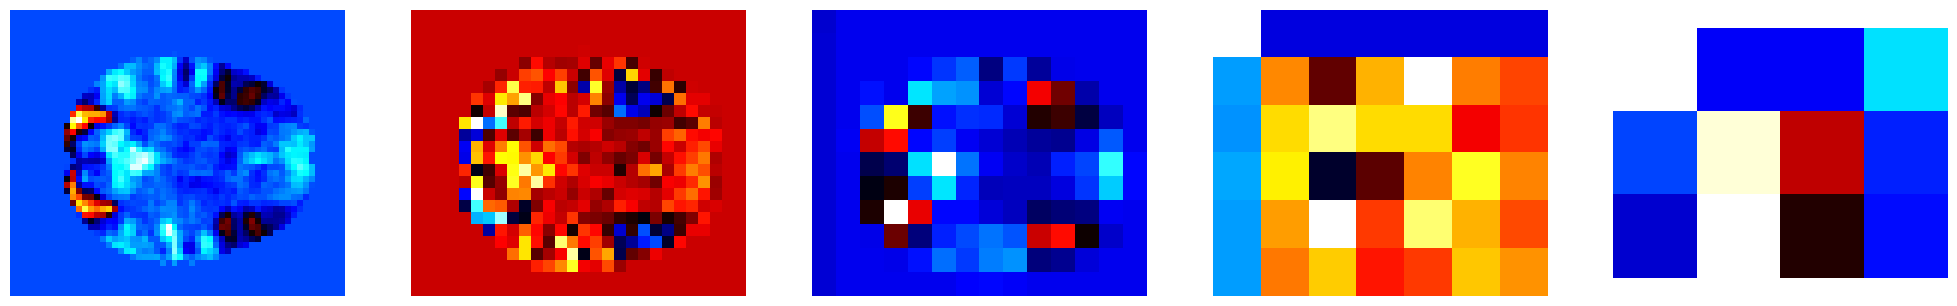

PUNISH


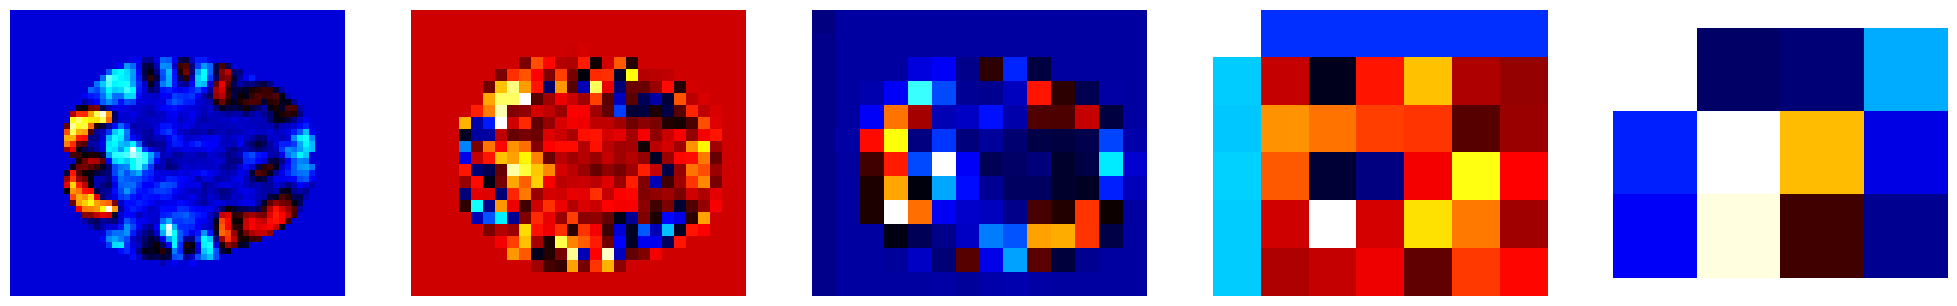

REL


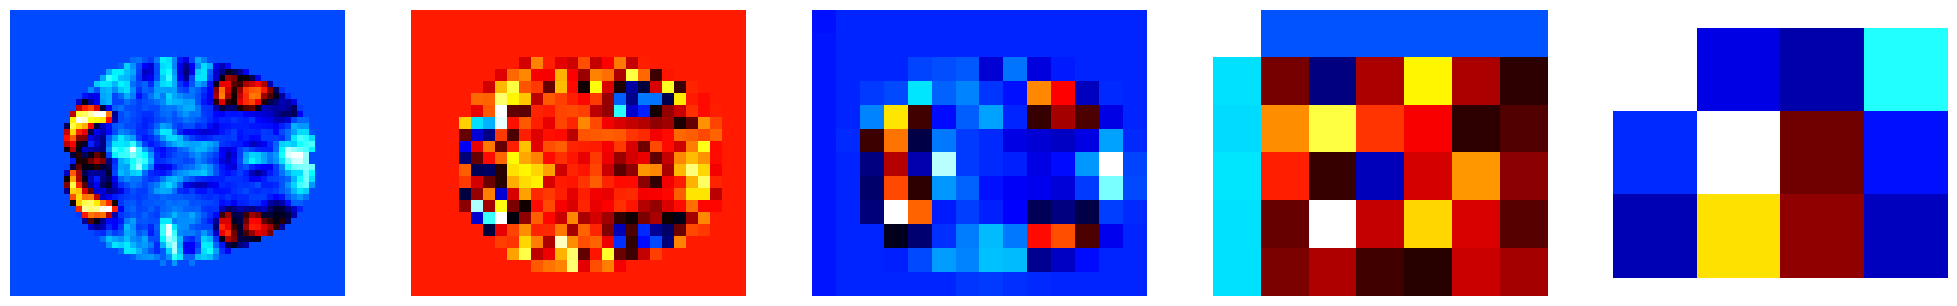

REWARD


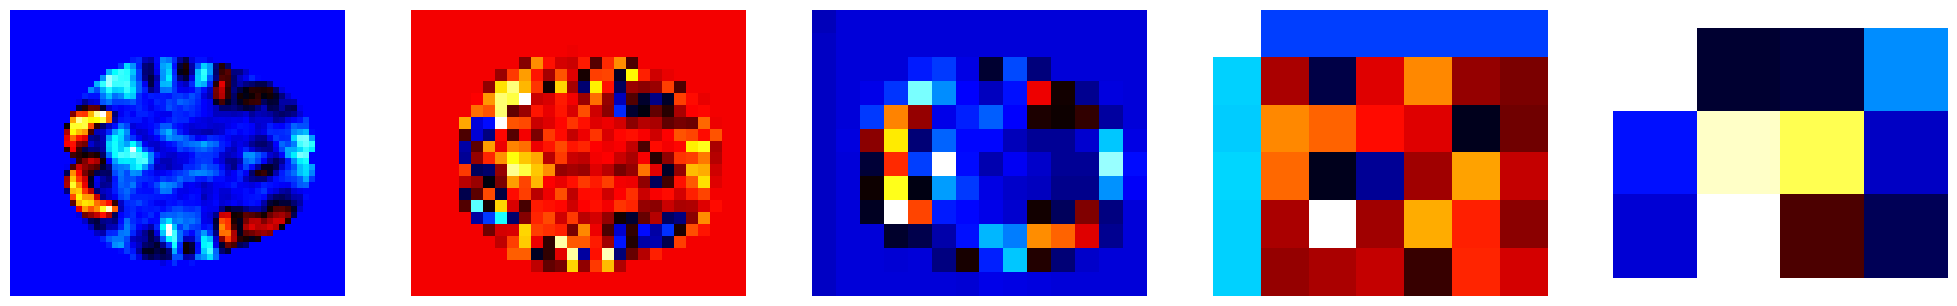

In [10]:
correlations_pt = {}
classes_names = ['WM: 0-BACK BODY', 'WM: 0-BACK PLACE', 'WM: 0-BACK TOOL','WM: 2-BACK BODY','WM: 2-BACK TOOL',
                 'GAMBLING: PUNISH', 'RELATIONAL', 'GAMBLING: REWARD']
for i, classes in enumerate(lab_to_analyze):
    print(classes)
    correlations_pt[classes] = visualize_features.visualize_features(cnn_pt_latent, test_set, classe=classes, 
                                                                     classe_name=classes_names[i],
                                                                     types='PT', print_title=False)

In [11]:
for classes in lab_to_analyze:
    print(classes)
    print(np.mean(correlations_pt[classes][0]))
    print(np.mean(correlations_pt[classes][1]))
    print(np.mean(correlations_pt[classes][2]))
    print(np.mean(correlations_pt[classes][3]))
    print(np.mean(correlations_pt[classes][4]))

0BK_BODY
0.2854587883179037
0.20239771075227198
0.5135000922750327
0.8736541612687156
0.727043140184997
0BK_PLACE
0.33772627197246274
0.2446129876799577
0.5900568308704849
0.9103254870943269
0.8286221062603667
0BK_TOOL
0.31288357944711576
0.21664405845485205
0.5330735425259767
0.878309929652825
0.8109436574736203
2BK_BODY
0.25956177836624095
0.18482279684051994
0.49223359524958515
0.884274930056091
0.80154780890785
2BK_TOOL
0.32423889344485285
0.22861670648892096
0.5649612349374881
0.9068278691799593
0.8590874996872297
PUNISH
0.31270012644885725
0.21824411047430783
0.5363471437582897
0.8933100543427575
0.7997342933991665
REL
0.4400231677300341
0.3304835710059336
0.6872745141822759
0.910755243309599
0.794261425159944
REWARD
0.33878351330558004
0.23885438840973355
0.5654815110388671
0.8963301185248953
0.7761680660166361


0BK_BODY


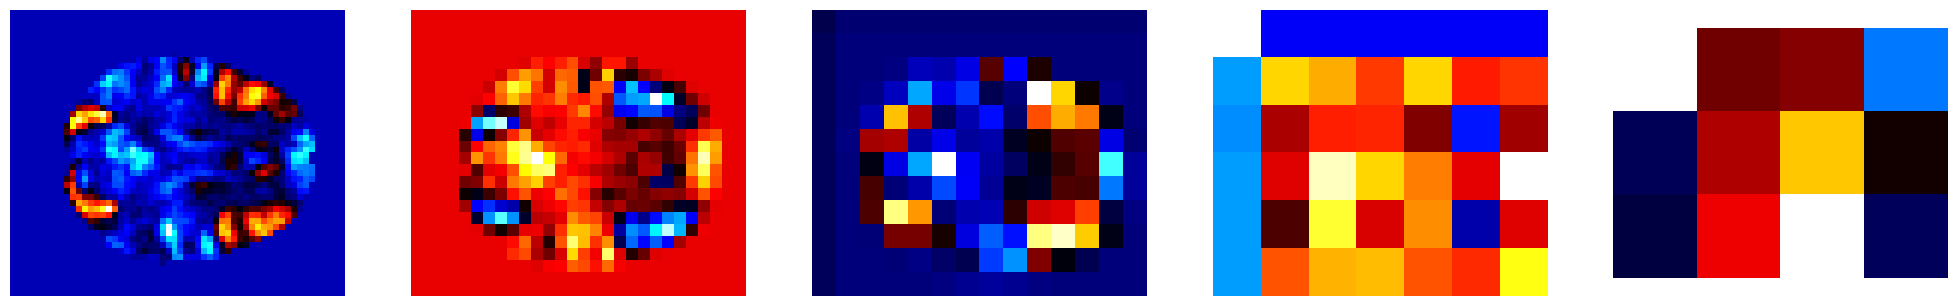

0BK_PLACE


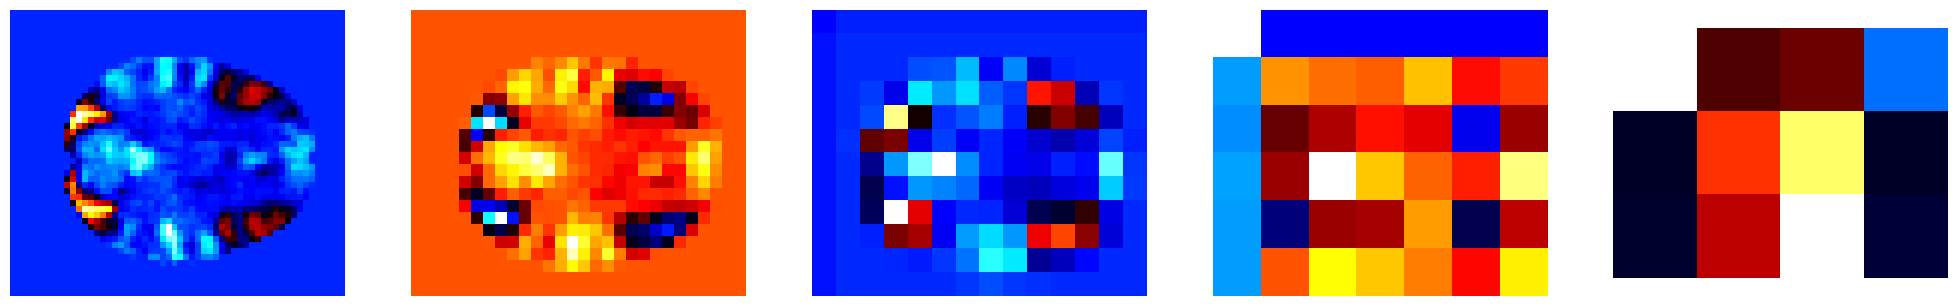

0BK_TOOL


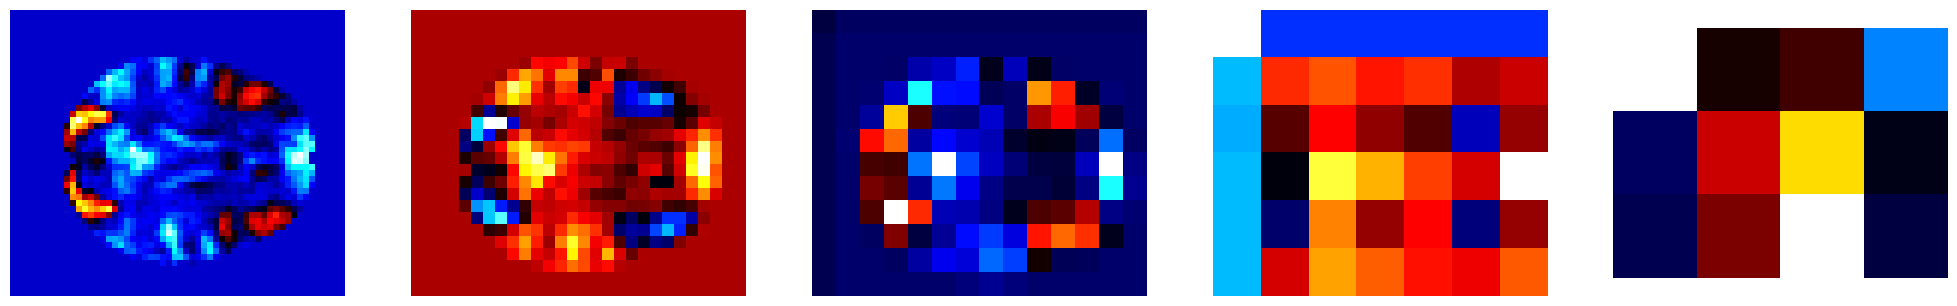

2BK_BODY


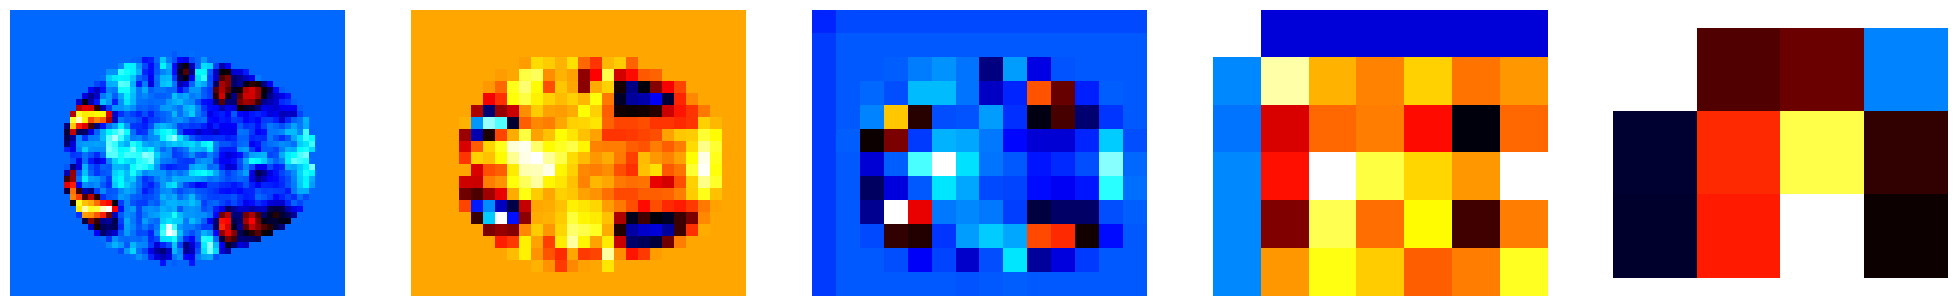

2BK_TOOL


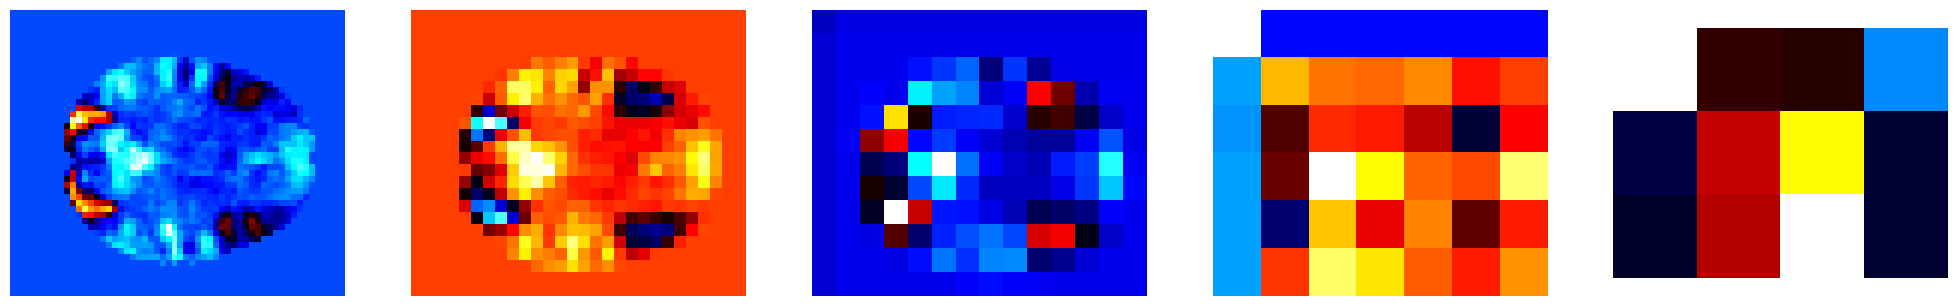

PUNISH


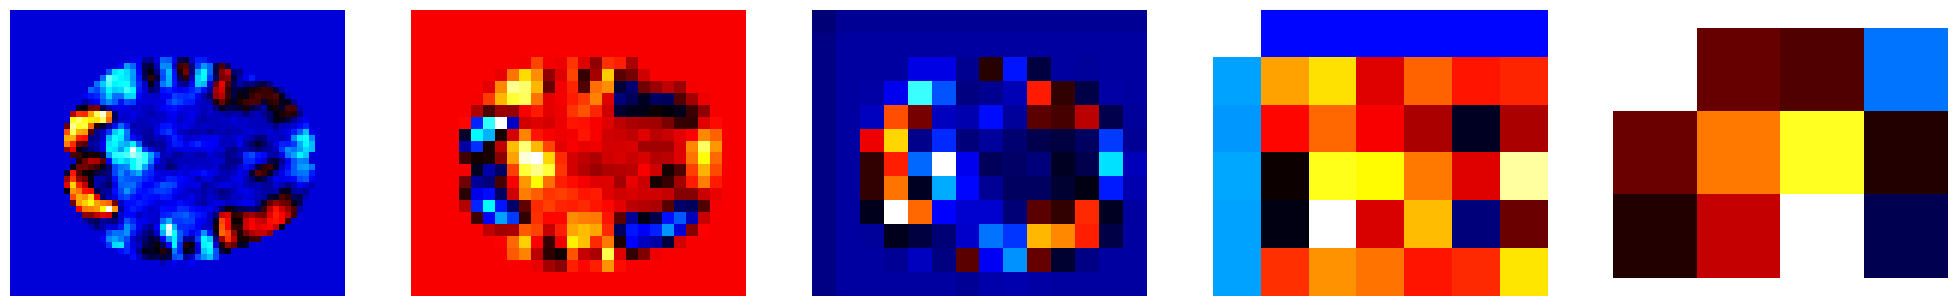

REL


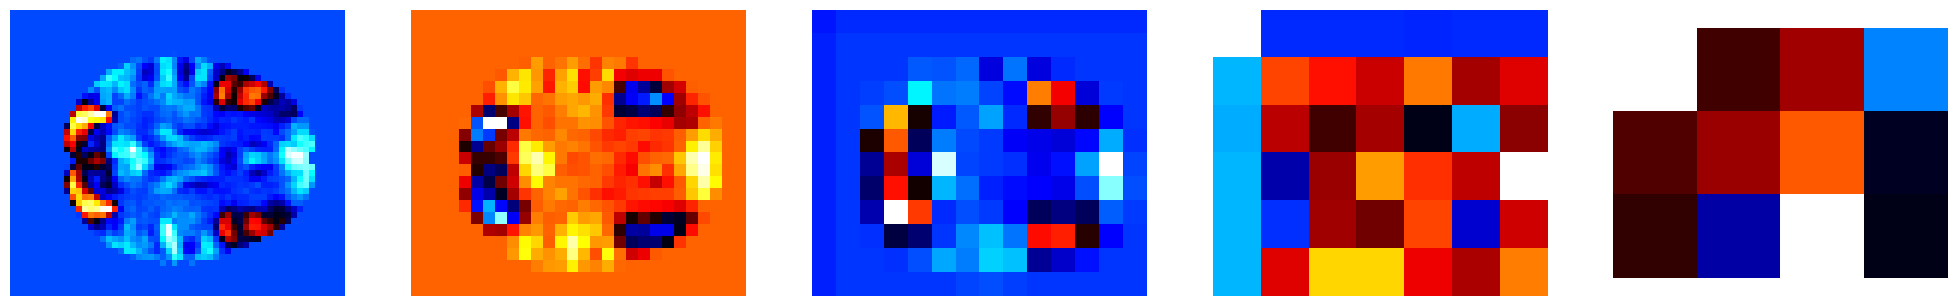

REWARD


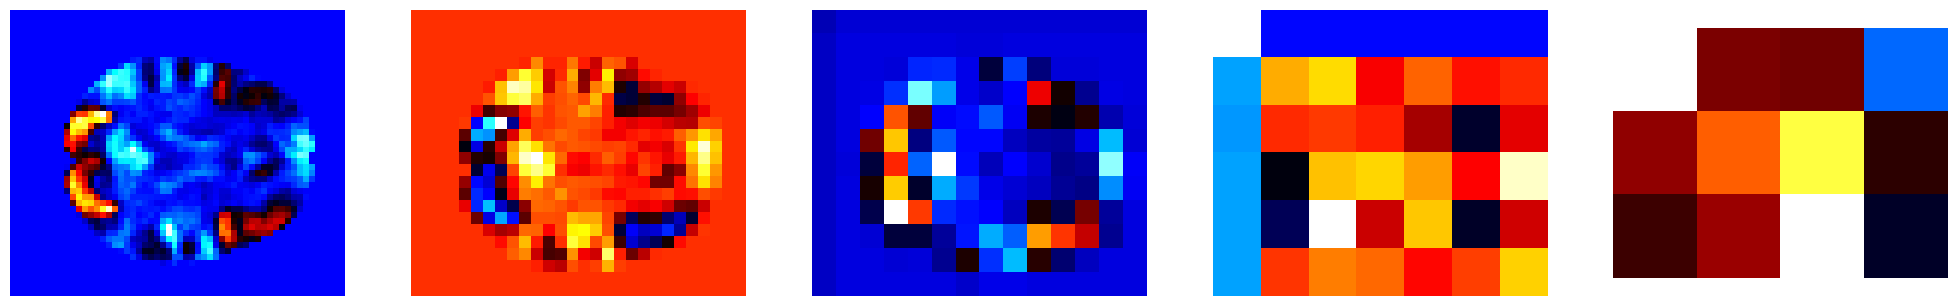

In [12]:
correlations_ae={}
classes_names = ['WM: 0-BACK BODY', 'WM: 0-BACK PLACE', 'WM: 0-BACK TOOL','WM: 2-BACK BODY','WM: 2-BACK TOOL',
                 'GAMBLING: PUNISH', 'RELATIONAL', 'GAMBLING: REWARD']
for i, classes in  enumerate(lab_to_analyze):
    print(classes)
    correlations_ae[classes]=visualize_features.visualize_features(ae_latent, test_set, classe=classes,
                                                                   classe_name=classes_names[i],
                                                                   types='AE', 
                                                                  print_title=False)

In [13]:
for classes in lab_to_analyze:
    print(classes)
    print(np.mean(correlations_ae[classes][1]))
    print(np.mean(correlations_ae[classes][2]))
    print(np.mean(correlations_ae[classes][3]))
    print(np.mean(correlations_ae[classes][4]))

0BK_BODY
0.43782931493209537
0.514947204338076
0.8349645815149196
0.8900124449604719
0BK_PLACE
0.5078842295751248
0.5912208994969205
0.8802006023922614
0.9276232855415283
0BK_TOOL
0.45862057053039107
0.5348490642287753
0.855636096496569
0.9137282545474018
2BK_BODY
0.41485207651013717
0.4937901867977844
0.8495423451648344
0.9186315420523733
2BK_TOOL
0.4849876399929108
0.5672830616565162
0.876533402202761
0.9370271231383775
PUNISH
0.465439661024284
0.5395518715850313
0.8603867989361937
0.9176912293120841
REL
0.6140225237581223
0.689440502514612
0.8729468884687932
0.9098610881517545
REWARD
0.4934786346300169
0.5683763645750581
0.8691518940220407
0.920561389212082


In [14]:
# Create dataframe of correlations for plotting
import os
import pandas as pd
if not os.path.exists('../figures/correlations_features.csv'):
    df = pd.DataFrame(columns=['Labels', 'Model', 'Layer', 'Correlation'])

    for labels in correlations.keys():
        for layers in range(1,5):
            df = df.append({'Labels':labels, 'Model':'DA', 'Layer':layers, 'Correlation': np.mean(correlations[labels][layers])}, ignore_index=True)
            df = df.append({'Labels':labels, 'Model':'PT', 'Layer':layers, 'Correlation': np.mean(correlations_pt[labels][layers])},ignore_index=True)
            df = df.append({'Labels':labels, 'Model':'AE', 'Layer':layers, 'Correlation': np.mean(correlations_ae[labels][layers])},ignore_index=True)

    df.to_csv('../figures/correlations_features.csv')
else:
    df = pd.read_csv('../figures/correlations_features.csv')

/var/folders/k4/cck9mrt578q044z6x6zmsnc400m_jt/T/ipykernel_60810/4085111093.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Labels':labels, 'Model':'DA', 'Layer':layers, 'Correlation': np.mean(correlations[labels][layers])}, ignore_index=True)
/var/folders/k4/cck9mrt578q044z6x6zmsnc400m_jt/T/ipykernel_60810/4085111093.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Labels':labels, 'Model':'PT', 'Layer':layers, 'Correlation': np.mean(correlations_pt[labels][layers])},ignore_index=True)
/var/folders/k4/cck9mrt578q044z6x6zmsnc400m_jt/T/ipykernel_60810/4085111093.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'Labels':labels, 'Model':'AE', 'Layer':layers, 'Correla

<Figure size 1600x1000 with 0 Axes>

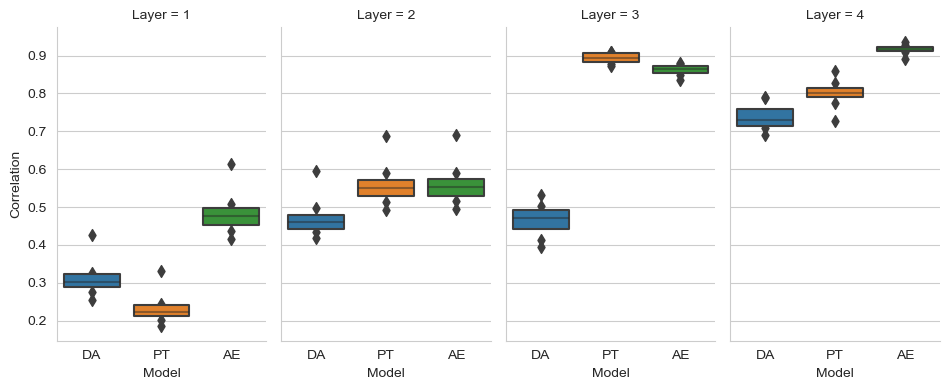

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
f = plt.figure(figsize=(16,10))

sns.set_style("whitegrid")
sns.catplot(data=df, x="Model", y="Correlation", col="Layer", dodge=True,
            height=4, aspect=.6, kind = 'boxen')

plt.savefig('../figures/fig10.png')
plt.show()


## Layers of importance

In [28]:
# Frozen layers 
import os
print('Calculating performance...')
out_dir = '../data/derived/HCP_dataset'
accuracies = []
f1_list = []
prec_list = []
rec_list = []
prec_list = []
model_list = []
n_list=[]
froz_list = []

lr = '1e-04'

n='50'    # Name of the training set used 
train_subset ='hcp_dataset_' + n
test_subset = 'hcp_dataset_' + n
if not os.path.exists('../figures/frozen_layers_analysis.csv'):
    for i in range(5):
        # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
        test_id_file = opj(data_dir, f'test_perf_hcp_dataset_fold_{i}.txt')
        label_file = opj(data_dir, f'hcp_dataset_labels.csv')
        label_col = 'contrast'
        label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                     f'hcp_dataset_labels.csv'))

        label_list = sorted(np.unique(label_filelist['contrast']))

        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        # Compute results performance for PRE-TRAINED CAE 
        for frozen in [2,3,4,5]:
            model = f'model_cnn_5layers_valid_perf_retrain_all_frozen_{frozen}_transfered_21'
            epochs = 200
            batch=64
            model_list.append('Pre-trained CAE')

            parameter_file = opj(out_dir, 
                f'{train_subset}_maps_classification_{label_col}_' + \
                                 f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_final_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)
            acc_class_pt = acc_class

            accuracies.append(acc)
            froz_list.append(frozen)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)

    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Precision']=prec_list
    df['Recall']= rec_list
    df['Subject']=n_list
    df['Frozen layer']=froz_list
    df.to_csv('../figures/frozen_layers_analysis.csv')
else:
    df=pd.read_csv('../figures/frozen_layers_analysis.csv')

Calculating performance...


In [31]:
for f in [2,3,4,5]:
    print(str(round(np.mean(df['Accuracy'][df['Frozen layer']==f]) * 100, 2))+' (' +
          str(round(np.std(df['Accuracy'][df['Frozen layer']==f])/np.sqrt(5) * 100, 2)) + ')')

86.7 (0.54)
86.82 (0.66)
86.1 (0.64)
80.42 (0.99)


In [33]:
# Transfered layers
print('Calculating performance...')
out_dir = '../data/derived/HCP_dataset'
accuracies = []
f1_list = []
prec_list = []
rec_list = []
prec_list = []
model_list = []
n_list=[]
trans_list = []

lr = '1e-04'

n='50'    # Name of the training set used 
train_subset ='hcp_dataset_' + n
test_subset = 'hcp_dataset_' + n
if not os.path.exists('../figures/transfered_layers_analysis.csv'):
    for i in range(5):
        # Cross-validation - Each model was tested on the corresponding testing fold of the GLOBAL HCP dataset
        test_id_file = opj(data_dir, f'test_perf_hcp_dataset_fold_{i}.txt')
        label_file = opj(data_dir, f'hcp_dataset_labels.csv')
        label_col = 'contrast'
        label_filelist = pd.read_csv(opj('../data/preprocessed/HCP_dataset', 
                                     f'hcp_dataset_labels.csv'))

        label_list = sorted(np.unique(label_filelist['contrast']))

        test_set = datasets.ClassifDataset(opj(data_dir, preprocess_type), test_id_file, label_file, label_col,
                                          label_list)

        # Compute results performance for PRE-TRAINED CAE 
        for transfered in [7,14,21,28]:
            model = f'model_cnn_5layers_valid_perf_retrain_all_frozen_0_transfered_{transfered}'
            epochs = 200
            batch=64
            model_list.append('Pre-trained CAE')

            parameter_file = opj(out_dir, 
                f'{train_subset}_maps_classification_{label_col}_' + \
                                 f'{model}_{preprocess_type}_epochs_{epochs}_batch_size_{batch}_lr_{lr}', 
                                         f'model_final_fold_{i}.pt')

            acc, f1, prec, rec, acc_class = cnn_tester.tester(test_set, parameter_file)
            acc_class_pt = acc_class

            accuracies.append(acc)
            trans_list.append(transfered)
            f1_list.append(f1)
            n_list.append(n)
            prec_list.append(prec)
            rec_list.append(rec)

    df = pd.DataFrame()
    df['Accuracy']=accuracies
    df['F1']=f1_list
    df['Model']=model_list
    df['Precision']=prec_list
    df['Recall']= rec_list
    df['Subject']=n_list
    df['Transfered layer']=trans_list
    df.to_csv('../figures/transfered_layers_analysis.csv')
else:
    df=pd.read_csv('../figures/transfered_layers_analysis.csv')

Calculating performance...


In [35]:
for t in [7,14,21,28]:
    print(str(round(np.mean(df['Accuracy'][df['Transfered layer']==t]) * 100, 2))+ ' (' + 
         str(round(np.std(df['Accuracy'][df['Transfered layer']==t]/np.sqrt(5) * 100), 2)) + ')')

82.67 (0.45)
84.79 (0.52)
85.51 (0.8)
86.6 (0.4)
